In [38]:
import pandas as pd
import numpy as np
import copy

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import IsolationForest
import seaborn as sn
import matplotlib.pyplot as plt

import src.utils as utils

# Load Config File

In [39]:
CONFIG_DATA = utils.config_load()
CONFIG_DATA

{'raw_dataset_path': 'data/raw/data.csv',
 'data_set_path': 'data/output/data.pkl',
 'input_set_path': 'data/output/input.pkl',
 'output_set_path': 'data/output/output.pkl',
 'input_columns_path': 'data/output/input_columns.pkl',
 'train_set_path': ['data/output/X_train.pkl', 'data/output/y_train.pkl'],
 'valid_set_path': ['data/output/X_valid.pkl', 'data/output/y_valid.pkl'],
 'test_set_path': ['data/output/X_test.pkl', 'data/output/y_test.pkl'],
 'output_column': 'Class',
 'seed': 42,
 'test_size': 0.2,
 'standardizer_path': 'data/output/standardizer.pkl',
 'preprocessor_path': 'data/output/preprocessor.pkl',
 'train_clean_path': ['data/output/X_train_clean.pkl',
  'data/output/y_train_clean.pkl'],
 'valid_clean_path': ['data/output/X_valid_clean.pkl',
  'data/output/y_valid_clean.pkl'],
 'test_clean_path': ['data/output/X_test_clean.pkl',
  'data/output/y_test_clean.pkl'],
 'list_of_model_path': 'log/list_of_model.pkl',
 'list_of_param_path': 'log/list_of_param.pkl',
 'list_of_tuned

# Create Model

Model of Choice
- Isolation Forest
- LOF (Local Outlier Factor)

## Isolation Forest

We are going to use all the data points available (the clean one)

In [40]:
X_train = utils.pickle_load(CONFIG_DATA['train_clean_path'][0])
X_valid = utils.pickle_load(CONFIG_DATA['valid_clean_path'][0])
X_test = utils.pickle_load(CONFIG_DATA['test_clean_path'][0])

y_train = utils.pickle_load(CONFIG_DATA['train_clean_path'][1])
y_valid = utils.pickle_load(CONFIG_DATA['valid_clean_path'][1])
y_test = utils.pickle_load(CONFIG_DATA['test_clean_path'][1])

In [41]:
features = pd.concat([X_train, X_valid, X_test]).reset_index(drop=True)
labels = pd.concat([y_train, y_valid, y_test]).reset_index(drop=True)

In [42]:
features.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.881629,1.917132,-0.270116,-0.724570,1.232514,0.176868,0.671585,-0.324136,0.183471,0.945501,...,-0.191685,-0.521906,-1.260449,0.275253,-1.233377,-0.216956,-1.055328,0.050492,-0.047530,0.105637
1,-0.776352,-2.464211,1.191720,-1.662436,0.324835,1.644393,3.377992,-0.762286,1.924346,0.427701,...,-0.307218,-0.113684,-0.029322,0.345004,0.957777,0.238767,-0.257482,0.055758,-0.065821,0.724549
2,-0.076882,1.144868,-0.233643,0.326144,-0.090142,-0.343074,0.139178,-0.403327,0.299978,0.200683,...,-0.219942,-0.000669,-0.044102,0.097355,-0.260501,0.019398,0.994229,-0.063142,-0.014753,-0.168513
3,-0.355373,-2.474770,1.864723,0.394075,1.512943,-1.356818,1.141271,-1.390996,2.106331,0.337888,...,-0.252878,-0.281465,-0.716155,0.047440,-0.773121,0.179948,-0.326727,-0.171670,-0.088989,-0.029961
4,1.020123,2.143241,-0.935954,-0.611902,-0.879246,-0.861117,-0.386023,-0.929392,-0.138473,-0.065163,...,0.115463,0.338995,1.052014,0.134982,0.805107,-0.088917,-0.127099,0.010406,-0.035502,0.112670


In [43]:
labels.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [44]:

to_model_cols = features.columns[0:30]
clf = IsolationForest(n_estimators=10, 
                      max_samples='auto', 
                      contamination=float(0.2/100), # number of anomaly in our data
                      max_features=1.0, 
                      bootstrap=False, 
                      n_jobs=-1, 
                      random_state=12345, 
                      verbose=0)
clf.fit(features[to_model_cols])

pred = clf.predict(features[to_model_cols])
features['Class'] = pred
outliers = features.loc[features['Class']==-1]
outlier_index=list(outliers.index)
#Find the number of anomalies and normal points (points classified as "-1" are anomalous)
print(features['Class'].value_counts())

c:\Users\david\miniconda3\envs\dev\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    102984
-1       207
Name: Class, dtype: int64


In [45]:
features['Class'] = features['Class'].map({1 : 0 , -1: 1})

<AxesSubplot: >

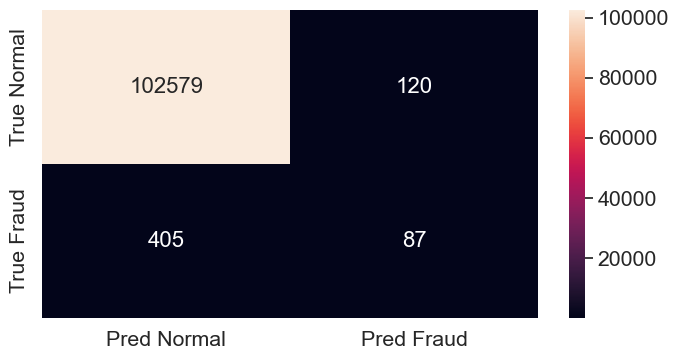

In [49]:
if_cm=confusion_matrix(labels, features['Class'])
df_cm = pd.DataFrame(if_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
plt.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

### Local Outlier Factor

In [48]:
from sklearn.neighbors import LocalOutlierFactor

clf_lof = LocalOutlierFactor(n_neighbors=30, 
                             algorithm='auto', 
                             contamination=.002)

# data_50k_new = standardized_data_without_class[0:50000]
# data_50k_df = pd.DataFrame(data=data_50k_new)

y_pred = clf_lof.fit_predict(features)

LOF_Scores = clf_lof.negative_outlier_factor_
LOF_pred=pd.Series(y_pred).replace([-1,1],[1,0])

<AxesSubplot: >

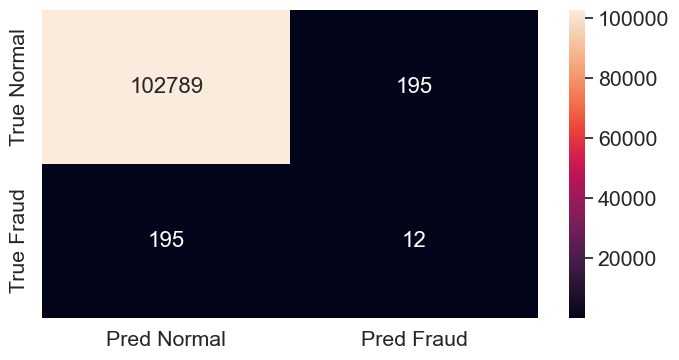

In [50]:
lof_cm=confusion_matrix(LOF_pred, features['Class'])
df_cm = pd.DataFrame(lof_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
plt.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size